In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 78


In [4]:
def max_multiple(number, base=4):
    return base * int(number/base)

min_x, min_y = min(specgram.shape[1] for specgram in specgrams), specgrams[0].shape[0]
min_x_mult, min_y_mult, min_x_50 = max_multiple(min_x), max_multiple(min_x), int(1.5*min_x)
print(min_x, min_y)
print(min_x_mult, min_y_mult, min_x_50)

68 64
68 68 102


In [5]:
# Reshape spectrograms by limiting number of columns to a max
reshape = []
for specgram in specgrams:
    reshape.append(specgram[:min_y_mult, :min_x_mult])
    if specgram.shape[1] > min_x_50:
        reshape.append(specgram[:min_y_mult, -min_x_mult:])  # if columns is > 1.5*min_size, append the last min_size columns

#Flip
augment = []
for specgram in reshape:
    augment.append(specgram)
    augment.append(np.flip(specgram, 0))  # flip rows / y axis
    augment.append(np.flip(specgram, 1))  # flip columns / x axis
    augment.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(augment))

384


In [6]:
# Obtain 3 dimensional shape
dim = augment[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(64, 68, 1)


In [7]:
# Split dataset between train and test
X_train, X_test = train_test_split(augment, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 288
Test samples: 96


In [8]:
# Add gaussian noise
noise_factor = 0.1

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

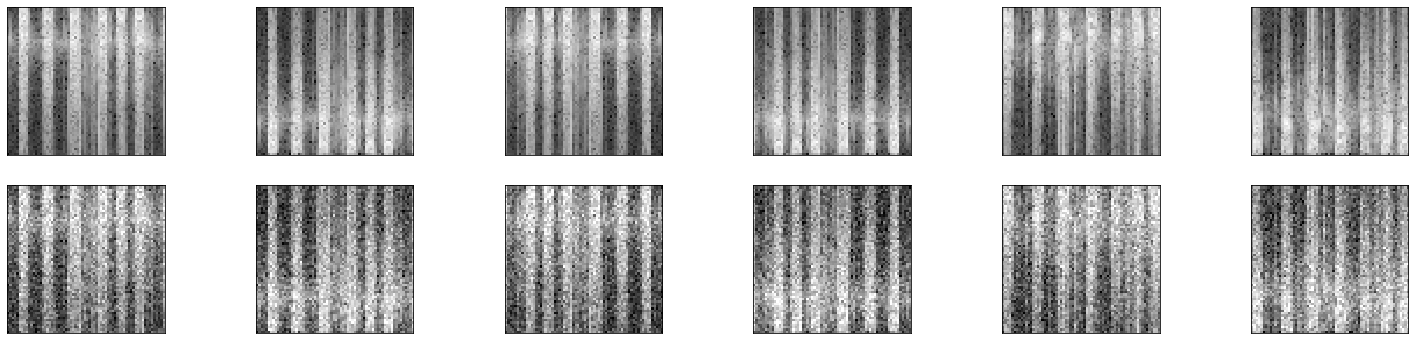

In [9]:
# Visualize original x noisy
n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_train_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [10]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [11]:
input_img = Input(shape=dim)

# encoder
code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(1, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = Flatten()(code)
bottleneck = Dense(128, activation='relu')(code)  # bottleneck

# decoder
x_hat = Dense(272, activation='relu')(bottleneck)
x_hat = Reshape((16, 17, 1))(x_hat)
x_hat = Conv2DTranspose(4, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(16, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 68, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 68, 16)        416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 68, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 34, 4)         1604      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 34, 4)         16        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 4)         0         
__________

In [12]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='best_model_128.h5', monitor='val_loss', save_best_only=True)]

In [13]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 1000

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks, # Early stopping
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 288 samples, validate on 96 samples
Epoch 1/2000
288/288 [==============================] - 2s 9ms/step - loss: 0.0681 - val_loss: 0.0494
Epoch 2/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0442 - val_loss: 0.0460
Epoch 3/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0393 - val_loss: 0.0414
Epoch 4/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0383 - val_loss: 0.0349
Epoch 5/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0351 - val_loss: 0.0435
Epoch 6/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0331 - val_loss: 0.0376
Epoch 7/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0326 - val_loss: 0.0345
Epoch 8/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0298 - val_loss: 0.0327
Epoch 9/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0292 - val_loss: 0.0377
Epoch 10/2000
288/288 [==============

288/288 [==============================] - 2s 6ms/step - loss: 0.0196 - val_loss: 0.0241
Epoch 160/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0192 - val_loss: 0.0236
Epoch 161/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0192 - val_loss: 0.0239
Epoch 162/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0189 - val_loss: 0.0237
Epoch 163/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0190 - val_loss: 0.0234
Epoch 164/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0192 - val_loss: 0.0231
Epoch 165/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0186 - val_loss: 0.0237
Epoch 166/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0191 - val_loss: 0.0246
Epoch 167/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0186 - val_loss: 0.0233
Epoch 168/2000
288/288 [==============================] - 2s 6ms/step - loss: 0

Epoch 238/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0160 - val_loss: 0.0204
Epoch 239/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0159 - val_loss: 0.0203
Epoch 240/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0157 - val_loss: 0.0203
Epoch 241/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0153 - val_loss: 0.0203
Epoch 242/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0158 - val_loss: 0.0216
Epoch 243/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0157 - val_loss: 0.0200
Epoch 244/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0156 - val_loss: 0.0203
Epoch 245/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0158 - val_loss: 0.0202
Epoch 246/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0156 - val_loss: 0.0202
Epoch 247/2000
288/288 [==============================] - 2s 6ms

Epoch 317/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0143 - val_loss: 0.0191
Epoch 318/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0145 - val_loss: 0.0199
Epoch 319/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0144 - val_loss: 0.0195
Epoch 320/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0143 - val_loss: 0.0187
Epoch 321/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0142 - val_loss: 0.0190
Epoch 322/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0143 - val_loss: 0.0192
Epoch 323/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0142 - val_loss: 0.0193
Epoch 324/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0144 - val_loss: 0.0192
Epoch 325/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0143 - val_loss: 0.0189
Epoch 326/2000
288/288 [==============================] - 2s 6ms

Epoch 396/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 0.0185
Epoch 397/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0137 - val_loss: 0.0183
Epoch 398/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0137 - val_loss: 0.0186
Epoch 399/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0135 - val_loss: 0.0180
Epoch 400/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0137 - val_loss: 0.0188
Epoch 401/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0135 - val_loss: 0.0180
Epoch 402/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 0.0184
Epoch 403/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0135 - val_loss: 0.0185
Epoch 404/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 0.0179
Epoch 405/2000
288/288 [==============================] - 2s 6ms

Epoch 475/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0130 - val_loss: 0.0178
Epoch 476/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0132 - val_loss: 0.0174
Epoch 477/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0130 - val_loss: 0.0181
Epoch 478/2000
288/288 [==============================] - 2s 6ms/step - loss: 0.0131 - val_loss: 0.0189
Epoch 479/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0131 - val_loss: 0.0181
Epoch 480/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0132 - val_loss: 0.0177
Epoch 481/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0130 - val_loss: 0.0184
Epoch 482/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0131 - val_loss: 0.0179
Epoch 483/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0128 - val_loss: 0.0185
Epoch 484/2000
288/288 [==============================] - 2s 7ms

Epoch 554/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0128 - val_loss: 0.0173
Epoch 555/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0125 - val_loss: 0.0172
Epoch 556/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0125 - val_loss: 0.0172
Epoch 557/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0124 - val_loss: 0.0177
Epoch 558/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0126 - val_loss: 0.0176
Epoch 559/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0126 - val_loss: 0.0179
Epoch 560/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0127 - val_loss: 0.0174
Epoch 561/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0127 - val_loss: 0.0175
Epoch 562/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0126 - val_loss: 0.0175
Epoch 563/2000
288/288 [==============================] - 2s 7ms

Epoch 633/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0172
Epoch 634/2000
288/288 [==============================] - 2s 8ms/step - loss: 0.0124 - val_loss: 0.0174
Epoch 635/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0125 - val_loss: 0.0171
Epoch 636/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0122 - val_loss: 0.0174
Epoch 637/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0124 - val_loss: 0.0176
Epoch 638/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0171
Epoch 639/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0172
Epoch 640/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0172
Epoch 641/2000
288/288 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0171
Epoch 642/2000
288/288 [==============================] - 2s 7ms

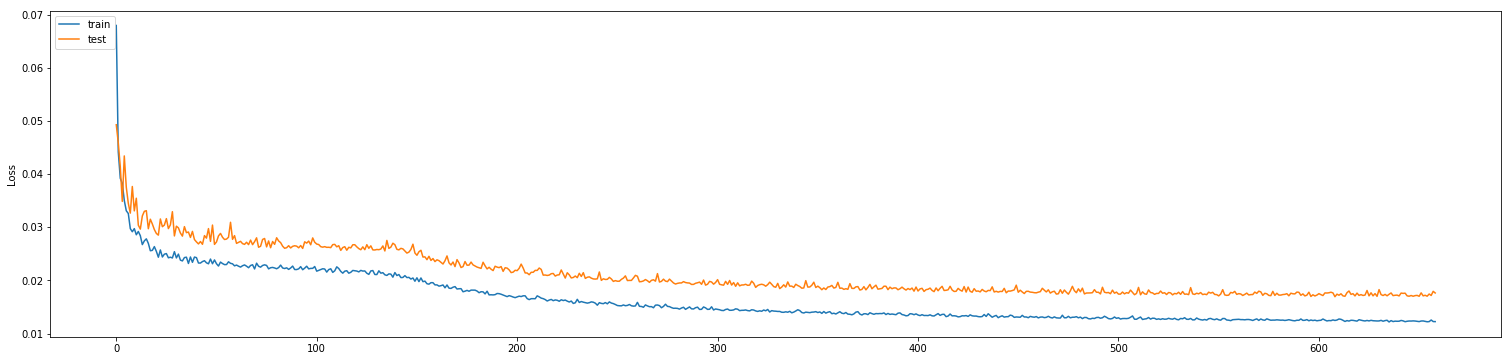

In [14]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# load best model
autoencoder = load_model('best_model_128.h5')

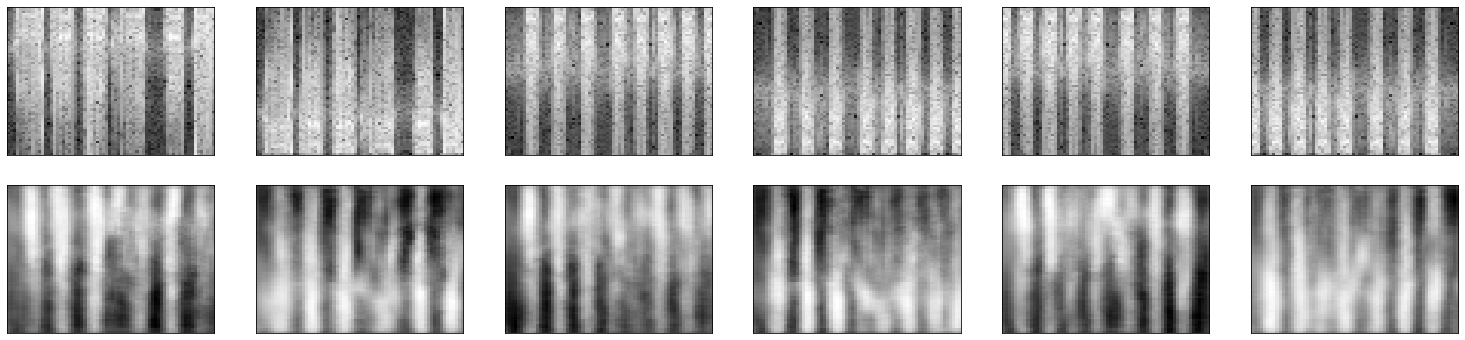

In [16]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

start, stop = 10, 16
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()